# Nested numerical solving problems

Scientific knowledge often takes the form of specific relationships
expressed by systems of equations. For example:

-   A system of ordinary differential equations connects some state
    variables $x$ with some other variables $v$ with equations with the
    form $\frac{dx}{dt}= f(x, v)$.
-   An algebraic equation systems says that some variables $v$ are
    related so that $f(v) = 0$
-   A differential algebraic equation system says that some state
    variables’ rates of change have the form $\frac{dx}{dt}= f(x, v)$
    and that they satisfy some algebraic constraints $f(x,v)=0$.

If there is an analytic solution to the equation system, we can just
include the solution in our statistical model like any other form of
structural knowledge: easy! However, often we want to solve equations
that are hard or impossible to solve analytically, but can be solved
approximately using numerical methods.

This is tricky in the context of Hamiltonian Monte Carlo for two
reasons:

1.  Computation: HMC requires many evaluations of the log probability
    density function and its gradients.

> **Important**
>
> At every evaluation, the sampler needs to solve the embedded equation
> system and find the gradients of the solution with respect to all
> model parameters.

1.  Extra source of error: how good of an approximation is good enough?

Reading:

-   Timonen et al. (2022)
-   Stan user guide sections: [algebraic equation
    systems](https://mc-stan.org/docs/stan-users-guide/algebraic-equations.html),
    [ODE systems](https://mc-stan.org/docs/stan-users-guide/odes.html),
    [DAE systems](https://mc-stan.org/docs/stan-users-guide/dae.html).

## Example

We have some tubes containing a substrate $S$ and some biomass $C$ that
we think approximately follow the Monod equation for microbial growth:

We measured $C$ and $S$ at different timepoints in some experiments and
we want to try and find out $\mu_{max}$, $K_{S}$ and $\gamma$ for the
different strains in the tubes.

You can read more about the Monod equation in Allen and Waclaw (2019).

### What we know

$\mu_{max}, K_S, \gamma, S, C$ are non-negative.

$S(0)$ and $C(0)$ vary a little by tube.

$\mu_{max}, K_S, \gamma$ vary by strain.

Measurement noise is roughly proportional to measured quantity.

### Statistical model

We use two regression models to describe the measurements:

To capture the variation in parameters by tube and strain we add a
hierarchical regression model:

To get a true abundance given some parameters we put an ode in the
model:

$$
\hat{C}(t), \hat{S}(t) = \text{solve-monod-equation}(t, C_0, S_0, \mu_max, \gamma, K_S)
$$

### imports

In [1]:
import itertools

import arviz as az
import cmdstanpy
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

### Specify true parameters

In order to avoid doing too much annoying handling of strings we assume
that all the parts of the problem have meaningful 1-indexed integer
labels: for example, species 1 is biomass.

This code specifies the dimensions of our problem.

In [2]:
N_strain = 4
N_tube = 16
N_timepoint = 20
duration = 15
strains = [i+1 for i in range(N_strain)]
tubes = [i+1 for i in range(N_tube)]
species = [1, 2]
measurement_timepoint_ixs = [4, 7, 12, 15, 17]
timepoints = pd.Series(
    np.linspace(0.01, duration, N_timepoint),
    name="time",
    index=range(1, N_timepoint+1)
)
SEED = 12345
rng = np.random.default_rng(seed=SEED)

This code defines some true values for the parameters - we will use
these to generate fake data.

In [3]:
true_param_values = {
    "a_mu_max": -1.7,
    "a_ks": -1.3,
    "a_gamma": -0.6,
    "t_mu_max": 0.2,
    "t_ks": 0.3,
    "t_gamma": 0.13,
    "species_zero": [
        [
            np.exp(np.random.normal(-2.1, 0.05)), 
            np.exp(np.random.normal(0.2, 0.05))
        ] for _ in range(N_tube)
    ],
    "sigma_y": [0.08, 0.1],
    "ln_mu_max_z": np.random.normal(0, 1, size=N_strain).tolist(),
    "ln_ks_z": np.random.normal(0, 1, size=N_strain).tolist(),
    "ln_gamma_z": np.random.normal(0, 1, size=N_strain).tolist(),
}
for var in ["mu_max", "ks", "gamma"]:
    true_param_values[var] = np.exp(
        true_param_values[f"a_{var}"]
        + true_param_values[f"t_{var}"] * np.array(true_param_values[f"ln_{var}_z"])
    ).tolist()

### A bit of data transformation

This code does some handy transformations on the data using pandas,
giving us a table of information about the measurements.

In [4]:
tube_to_strain = pd.Series(
    [
        (i % N_strain) + 1 for i in range(N_tube)  # % operator finds remainder
    ], index=tubes, name="strain"
)
measurements = (
    pd.DataFrame(
        itertools.product(tubes, measurement_timepoint_ixs, species),
        columns=["tube", "timepoint", "species"],
        index=range(1, len(tubes) * len(measurement_timepoint_ixs) * len(species) + 1)
    )
    .join(tube_to_strain, on="tube")
    .join(timepoints, on="timepoint")
)

### Generating a Stan input dictionary

This code puts the data in the correct format for cmdstanpy.

In [5]:
stan_input_structure = {
    "N_measurement": len(measurements),
    "N_timepoint": N_timepoint,
    "N_tube": N_tube,
    "N_strain": N_strain,
    "tube": measurements["tube"].values.tolist(),
    "measurement_timepoint": measurements["timepoint"].values.tolist(),
    "measured_species": measurements["species"].values.tolist(),
    "strain": tube_to_strain.values.tolist(),
    "timepoint_time": timepoints.values.tolist(),
}

This code defines some prior distributions for the model’s parameters

In [6]:
priors = {
    # parameters that can be negative:
    "prior_a_mu_max": [-1.8, 0.2],
    "prior_a_ks": [-1.3, 0.1],
    "prior_a_gamma": [-0.5, 0.1],
    # parameters that are non-negative:
    "prior_t_mu_max": [-1.4, 0.1],
    "prior_t_ks": [-1.2, 0.1],
    "prior_t_gamma": [-2, 0.1],
    "prior_species_zero": [[[-2.1, 0.1], [0.2, 0.1]]] * N_tube,
    "prior_sigma_y": [[-2.3, 0.15], [-2.3, 0.15]],
}

The next bit of code lets us configure Stan’s interface to the Sundials
ODE solver.

In [7]:
ode_solver_configuration = {
    "abs_tol": 1e-7,
    "rel_tol": 1e-7,
    "max_num_steps": int(1e7)
}

Now we can put all the inputs together

In [8]:
stan_input_common = stan_input_structure | priors | ode_solver_configuration

### Load the model

This code loads the Stan program at `monod.stan` as a `CmdStanModel`
object and compiles it using cmdstan’s compiler.

In [9]:
model = cmdstanpy.CmdStanModel(stan_file="../src/stan/monod.stan")
print(model.code())

functions {
  real get_mu_at_t(real mu_max, real ks, real S_at_t) {
    return (mu_max * S_at_t) / (ks + S_at_t);
  }
  vector ddt(real t, vector species, real mu_max, real ks, real gamma) {
    real mu_at_t = get_mu_at_t(mu_max, ks, species[2]);
    vector[2] out;
    out[1] = mu_at_t * species[1];
    out[2] = -gamma * mu_at_t * species[1];
    return out;
  }
}
data {
  int<lower=1> N_measurement;
  int<lower=1> N_timepoint;
  int<lower=1> N_tube;
  int<lower=1> N_strain;
  array[N_measurement] int<lower=1, upper=N_tube> tube;
  array[N_measurement] int<lower=1, upper=N_timepoint> measurement_timepoint;
  array[N_measurement] int<lower=1, upper=2> measured_species;
  vector<lower=0>[N_measurement] y;
  array[N_tube] int<lower=1, upper=N_strain> strain;
  array[N_timepoint] real<lower=0> timepoint_time;
  array[N_tube, 2] vector[2] prior_species_zero;
  array[2] vector[2] prior_sigma_y;
  vector[2] prior_a_mu_max;
  vector[2] prior_a_ks;
  vector[2] prior_a_gamma;
  vector[2] prior_t

### Sample in fixed param mode to generate fake data

In [10]:
stan_input_true = stan_input_common | {
    "y": np.ones(len(measurements)).tolist(),  # dummy values as we don't need measurements yet
    "likelihood": 0                            # we don't need to evaluate the likelihood
}
coords = {
    "strain": strains,
    "tube": tubes,
    "species": species,
    "timepoint": timepoints.index.values,
    "measurement": measurements.index.values
}
dims = {
    "abundance": ["tube", "timepoint", "species"],
    "mu_max": ["strain"],
    "ks": ["strain"],
    "gamma": ["strain"],
    "species_zero": ["tube", "species"],
    "y": ["measurement"],
    "yrep": ["measurement"],
    "llik": ["measurement"]
}

mcmc_true = model.sample(
    data=stan_input_true,
    iter_sampling=1,
    fixed_param=True,
    chains=1,
    refresh=1,
    inits=true_param_values,
    seed=SEED,
)
idata_true = az.from_cmdstanpy(
    mcmc_true,
    dims=dims,
    coords=coords,
    posterior_predictive={"y": "yrep"},
    log_likelihood="llik"
)

17:10:48 - cmdstanpy - INFO - CmdStan start processing
17:10:48 - cmdstanpy - INFO - CmdStan done processing.

### Look at results

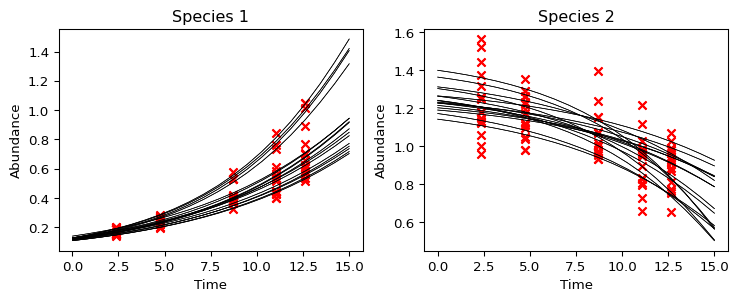

In [11]:
def plot_sim(true_abundance, fake_measurements, species_to_ax):
    f, axes = plt.subplots(1, 2, figsize=[9, 3])

    axes[species_to_ax[1]].set_title("Species 1")
    axes[species_to_ax[2]].set_title("Species 2")
    for ax in axes:
        ax.set_xlabel("Time")
        ax.set_ylabel("Abundance")
        for (tube_i, species_i), df_i in true_abundance.groupby(["tube", "species"]):
            ax = axes[species_to_ax[species_i]]
            fm = df_i.merge(
                fake_measurements.drop("time", axis=1),
                on=["tube", "species", "timepoint"]
            )
            ax.plot(
                df_i.set_index("time")["abundance"], color="black", linewidth=0.5
            )
            ax.scatter(
                fm["time"],
                fm["simulated_measurement"],
                color="r",
                marker="x",
                label="simulated measurement"
            )
    return f, axes

species_to_ax = {1: 0, 2: 1}
true_abundance = (
    idata_true.posterior["abundance"]
    .to_dataframe()
    .droplevel(["chain", "draw"])
    .join(timepoints, on="timepoint")
    .reset_index()
)
fake_measurements = measurements.join(
    idata_true.posterior_predictive["yrep"]
    .to_series()
    .droplevel(["chain", "draw"])
    .rename("simulated_measurement")
).copy()
f, axes = plot_sim(true_abundance, fake_measurements, species_to_ax)

f.savefig("img/monod_simulated_data.png")

### Sample in prior mode

In [12]:
stan_input_prior = stan_input_common | {
    "y": fake_measurements["simulated_measurement"],
    "likelihood": 0
}
mcmc_prior = model.sample(
    data=stan_input_prior,
    iter_warmup=100,
    iter_sampling=100,
    chains=1,
    refresh=1,
    save_warmup=True,
    inits=true_param_values,
    seed=SEED,
)
idata_prior = az.from_cmdstanpy(
    mcmc_prior,
    dims=dims,
    coords=coords,
    posterior_predictive={"y": "yrep"},
    log_likelihood="llik"
)
idata_prior

17:10:49 - cmdstanpy - INFO - CmdStan start processing
17:11:16 - cmdstanpy - INFO - CmdStan done processing.
17:11:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: initial state[2] is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
Consider re-running with show_console=True if the above output is unclear!

arviz.InferenceData 
 
 
 
 
 
 posterior 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset> Size: 564kB
Dimensions: (chain: 1, draw: 100, ln_mu_max_z_dim_0: 4,
 ln_ks_z_dim_0: 4, ln_gamma_z_dim_0: 4, tube: 16,
 species: 2, sigma_y_dim_0: 2, strain: 4, timepoint: 20)
Coordinates:
 * chain (chain) int64 8B 0
 * draw (draw) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
 * ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 32B 0 1 2 3
 * ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 32B 0 1 2 3
 * ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 32B 0 1 2 3
 * tube (tube) int64 128B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
 * species (species) int64 16B 1 2
 * sigma_y_dim_0 (sigma_y_dim_0) int64 16B 0 1
 * strain (strain) int64 32B 1 2 3 4
 * timepoint (timepoint) int64 160B 1 2 3 4 5 6 ... 15 16 17 18 19 20
Data variables: (12/15)
 ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 3kB 0.9335 .....
 ln_ks_z (chain, draw, ln_ks_z_dim_0) float64 3kB -0.1858 ... -...
 ln_gamma_z (chain, draw, ln_gamma_z_dim_0) float64 3kB 1.44 ... 0...
 a_mu_max (chain, draw) float64 800B -1.79 -1.803 ... -1.659 -1.558
 a_ks (chain, draw) float64 800B -1.104 -1.306 ... -1.295
 a_gamma (chain, draw) float64 800B -0.6453 -0.4565 ... -0.3662
 ... ...
 species_zero (chain, draw, tube, species) float64 26kB 0.1081 ... 1...
 sigma_y (chain, draw, sigma_y_dim_0) float64 2kB 0.09287 ... 0...
 mu_max (chain, draw, strain) float64 3kB 0.2202 0.144 ... 0.2575
 ks (chain, draw, strain) float64 3kB 0.3174 ... 0.2164
 gamma (chain, draw, strain) float64 3kB 0.6461 ... 0.7623
 abundance (chain, draw, tube, timepoint, species) float64 512kB ...
Attributes:
 created_at: 2024-04-29T15:11:16.820239
 arviz_version: 0.17.0
 inference_library: cmdstanpy
 inference_library_version: 1.2.1 xarray.Dataset Dimensions: chain : 1 draw : 100 ln_mu_max_z_dim_0 : 4 ln_ks_z_dim_0 : 4 ln_gamma_z_dim_0 : 4 tube : 16 species : 2 sigma_y_dim_0 : 2 strain : 4 timepoint : 20 Coordinates: (10) chain (chain) int64 0 array([0]) draw (draw) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99 array([ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]) ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) tube (tube) int64 1 2 3 4 5 6 7 ... 11 12 13 14 15 16 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]) species (species) int64 1 2 array([1, 2]) sigma_y_dim_0 (sigma_y_dim_0) int64 0 1 array([0, 1]) strain (strain) int64 1 2 3 4 array([1, 2, 3, 4]) timepoint (timepoint) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) Data variables: (15) ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 0.9335 -0.5012 ... -0.05547 0.8181 array([[[ 9.33488e-01, -5.01191e-01, -5.55441e-01, -5.38696e-01],
 [ 1.21740e-01, -9.93324e-01, 1.05106e+00, 1.32295e+00],
 [ 2.56043e-01, 5.98085e-01, 1.21055e-01, -2.44081e+00],
 [ 1.14305e-01, 4.45437e-01, 5.13157e-02, -2.32573e+00],
 [-4.72945e-01, -7.66241e-01, 1.23217e-01, 4.58159e-02],
 [-6.15443e-01, -6.46288e-01, -2.69725e-01, 4.54026e-01],
 [-9.60372e-01, 2.42025e-01, 7.14429e-01, -1.91664e+00],
 [-4.73416e-01, 5.72730e-01, 1.16608e+00, -2.02033e+00],
 [ 3.39727e-02, 1.88309e-01, -1.52846e+00, 1.26566e+00],
 [ 2.48212e-01, 6.71120e-01, 1.87809e-01, -1.99120e+00],
 [ 5.99161e-01, 3.43092e-02, 1.58552e+00, -1.66127e+00],
 [ 5.18545e-01, -8.34973e-03, 1.61486e+00, -1.67574e+00],
 [ 8.40908e-01, 2.44080e-01, 1.31286e+00, -1.78018e+00],
 [ 7.56913e-01, -1.02887e+00, 6.01663e-01, -5.37267e-01],
 [-3.04850e-01, 1.27218e

We can find the prior intervals for the true abundance and plot them in
the graph.

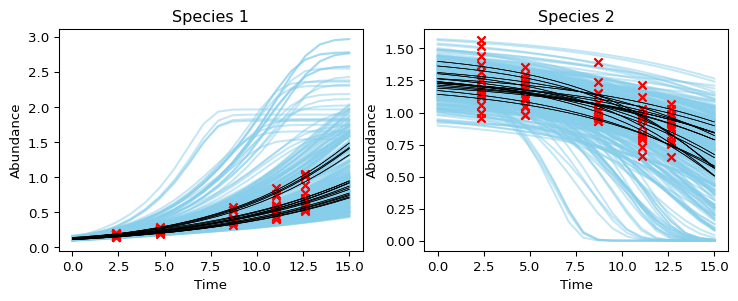

In [13]:
prior_abundances = idata_prior.posterior["abundance"]

n_sample = 20
chains = rng.choice(prior_abundances.coords["chain"].values, n_sample)
draws = rng.choice(prior_abundances.coords["draw"].values, n_sample)
f, axes = plot_sim(true_abundance, fake_measurements, species_to_ax)

for ax, species_i in zip(axes, species):
    for tube_j in tubes:
        for chain, draw in zip(chains, draws):
            timeseries = prior_abundances.sel(chain=chain, draw=draw, tube=tube_j, species=species_i)
            ax.plot(
                timepoints.values, 
                timeseries.values,
                alpha=0.5, color="skyblue", zorder=-1
            )
f.savefig("img/monod_priors.png")

### Sample in posterior mode

In [14]:
stan_input_posterior = stan_input_common | {
    "y": fake_measurements["simulated_measurement"],
    "likelihood": 1
}
mcmc_posterior = model.sample(
    data=stan_input_posterior,
    iter_warmup=300,
    iter_sampling=300,
    chains=4,
    refresh=1,
    inits=true_param_values,
    seed=SEED,
)
idata_posterior = az.from_cmdstanpy(
    mcmc_posterior,
    dims=dims,
    coords=coords,
    posterior_predictive={"y": "yrep"},
    log_likelihood="llik"
)
idata_posterior

17:11:17 - cmdstanpy - INFO - CmdStan start processing
17:14:33 - cmdstanpy - INFO - CmdStan done processing.
17:14:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79)
    Exception: ode_bdf_tol: ode parameters and data is inf, but must be finite! (in 'monod.stan', line 56, column 4 to line 60, column 79

arviz.InferenceData 
 
 
 
 
 
 posterior 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.Dataset> Size: 7MB
Dimensions: (chain: 4, draw: 300, ln_mu_max_z_dim_0: 4,
 ln_ks_z_dim_0: 4, ln_gamma_z_dim_0: 4, tube: 16,
 species: 2, sigma_y_dim_0: 2, strain: 4, timepoint: 20)
Coordinates:
 * chain (chain) int64 32B 0 1 2 3
 * draw (draw) int64 2kB 0 1 2 3 4 5 ... 294 295 296 297 298 299
 * ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 32B 0 1 2 3
 * ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 32B 0 1 2 3
 * ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 32B 0 1 2 3
 * tube (tube) int64 128B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
 * species (species) int64 16B 1 2
 * sigma_y_dim_0 (sigma_y_dim_0) int64 16B 0 1
 * strain (strain) int64 32B 1 2 3 4
 * timepoint (timepoint) int64 160B 1 2 3 4 5 6 ... 15 16 17 18 19 20
Data variables: (12/15)
 ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 38kB 0.5321 ....
 ln_ks_z (chain, draw, ln_ks_z_dim_0) float64 38kB 0.1823 ... -...
 ln_gamma_z (chain, draw, ln_gamma_z_dim_0) float64 38kB -0.9441 ....
 a_mu_max (chain, draw) float64 10kB -1.759 -1.691 ... -1.861
 a_ks (chain, draw) float64 10kB -1.357 -1.228 ... -1.283
 a_gamma (chain, draw) float64 10kB -0.4461 -0.4911 ... -0.505
 ... ...
 species_zero (chain, draw, tube, species) float64 307kB 0.1245 ... ...
 sigma_y (chain, draw, sigma_y_dim_0) float64 19kB 0.08247 ... ...
 mu_max (chain, draw, strain) float64 38kB 0.1948 ... 0.1521
 ks (chain, draw, strain) float64 38kB 0.2708 ... 0.2575
 gamma (chain, draw, strain) float64 38kB 0.5589 ... 0.6073
 abundance (chain, draw, tube, timepoint, species) float64 6MB 0....
Attributes:
 created_at: 2024-04-29T15:14:33.562368
 arviz_version: 0.17.0
 inference_library: cmdstanpy
 inference_library_version: 1.2.1 xarray.Dataset Dimensions: chain : 4 draw : 300 ln_mu_max_z_dim_0 : 4 ln_ks_z_dim_0 : 4 ln_gamma_z_dim_0 : 4 tube : 16 species : 2 sigma_y_dim_0 : 2 strain : 4 timepoint : 20 Coordinates: (10) chain (chain) int64 0 1 2 3 array([0, 1, 2, 3]) draw (draw) int64 0 1 2 3 4 5 ... 295 296 297 298 299 array([ 0, 1, 2, ..., 297, 298, 299]) ln_mu_max_z_dim_0 (ln_mu_max_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_ks_z_dim_0 (ln_ks_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) ln_gamma_z_dim_0 (ln_gamma_z_dim_0) int64 0 1 2 3 array([0, 1, 2, 3]) tube (tube) int64 1 2 3 4 5 6 7 ... 11 12 13 14 15 16 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]) species (species) int64 1 2 array([1, 2]) sigma_y_dim_0 (sigma_y_dim_0) int64 0 1 array([0, 1]) strain (strain) int64 1 2 3 4 array([1, 2, 3, 4]) timepoint (timepoint) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) Data variables: (15) ln_mu_max_z (chain, draw, ln_mu_max_z_dim_0) float64 0.5321 0.1364 ... 0.1702 -0.09331 array([[[ 0.532105 , 0.136371 , -0.766977 , -0.363241 ],
 [ 0.419965 , -0.112092 , -0.771595 , -0.369072 ],
 [-0.0837588, -0.832942 , -0.878136 , -1.08766 ],
 ...,
 [ 0.370069 , -0.437093 , -0.739176 , -0.542971 ],
 [ 0.576869 , -0.126509 , -0.295904 , -0.330055 ],
 [ 0.544433 , 0.3834 , -0.724924 , -0.864918 ]],

 [[ 1.02646 , 0.387863 , 0.262252 , 0.169808 ],
 [-0.0378015, -0.517501 , -1.23393 , -1.05519 ],
 [ 0.0477333, -0.501738 , -1.57372 , -1.14158 ],
 ...,
 [ 0.500022 , 0.573766 , -0.826856 , -0.223874 ],
 [ 0.249939 , 0.538406 , -0.961002 , -0.399069 ],
 [ 0.224462 , 0.327328 , -0.904078 , -0.62183 ]],

 [[ 0.650196 , 0.317776 , -0.0751557, 0.710357 ],
 [ 0.639716 , 0.13812 , -0.347398 , 0.0519453],
 [ 0.760391 , -0.0679353, -0.448393 , -0.461943 ],
 ...,
 [ 1.17293 , 0.477669 , 0.0959356, -0.300795 ],
 [ 0.804031 , 0.202645 , -0.0295001, -0.189448 ],
 [ 0.787383 , 0.328907 , -0.576335 , -0.260974 ]],

 [[ 0.259182 , -0.298089 , -0.634098 , -0.668457 ],
 [ 0.0431633, -0.0909208, -0.768149 , -0.712857 ],
 [ 0.28169 , -0.334477 , -0.747813 , -0.422593 ],
 ...,
 [ 0.696321 , 0.756655 , 0.151205 , -0.160117 ],
 [ 0.562551 , -0.0535495, -0.768874 , -0.326422 ],
 [ 1.134

# Diagnostics: is the posterior ok?

First check the `sample_stats` group to see if there were any divergent
transitions and if the `lp` parameter converged.

In [15]:
az.summary(idata_posterior.sample_stats)

/Users/tedgro/repos/biosustain/bayesian_statistics_for_computational_biology/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)

Next check the parameter-by-parameter summary

In [16]:
az.summary(idata_posterior)

704 rows × 9 columns

Show posterior intervals

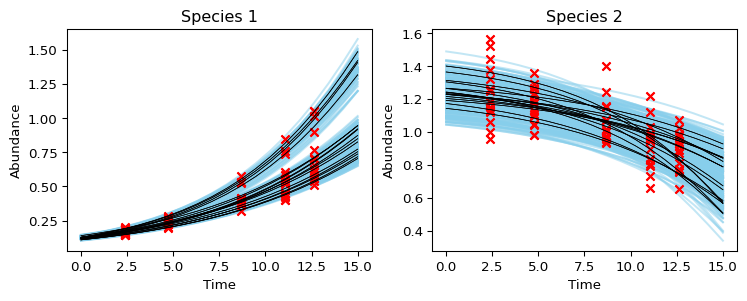

In [17]:
prior_abundances = idata_posterior.posterior["abundance"]

n_sample = 20
chains = rng.choice(prior_abundances.coords["chain"].values, n_sample)
draws = rng.choice(prior_abundances.coords["draw"].values, n_sample)
f, axes = plot_sim(true_abundance, fake_measurements, species_to_ax)

for ax, species_i in zip(axes, species):
    for tube_j in tubes:
        for chain, draw in zip(chains, draws):
            timeseries = prior_abundances.sel(chain=chain, draw=draw, tube=tube_j, species=species_i)
            ax.plot(
                timepoints.values, 
                timeseries.values,
                alpha=0.5, color="skyblue", zorder=-1
            )
f.savefig("img/monod_posteriors.png")

### look at the posterior

The next few cells use arviz’s
[`plot_posterior`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_posterior.html)
function to plot the marginal posterior distributions for some of the
model’s parameters:

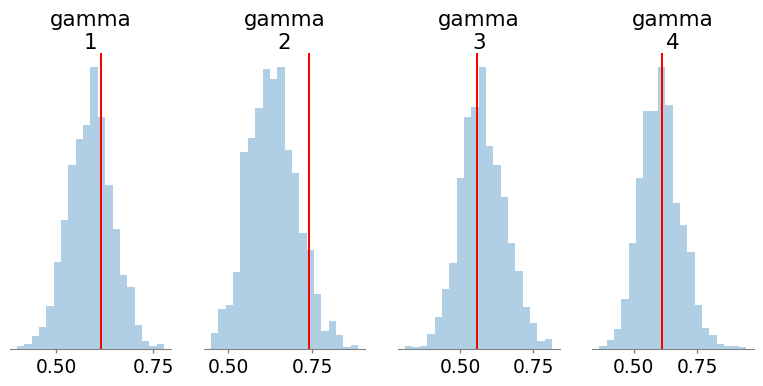

In [18]:
f, axes = plt.subplots(1, 4, figsize=[10, 4])
axes = az.plot_posterior(
    idata_posterior,
    kind="hist",
    bins=20,
    var_names=["gamma"],
    ax=axes,
    point_estimate=None,
    hdi_prob="hide"
)
for ax, true_value in zip(axes, true_param_values["gamma"]):
    ax.axvline(true_value, color="red")

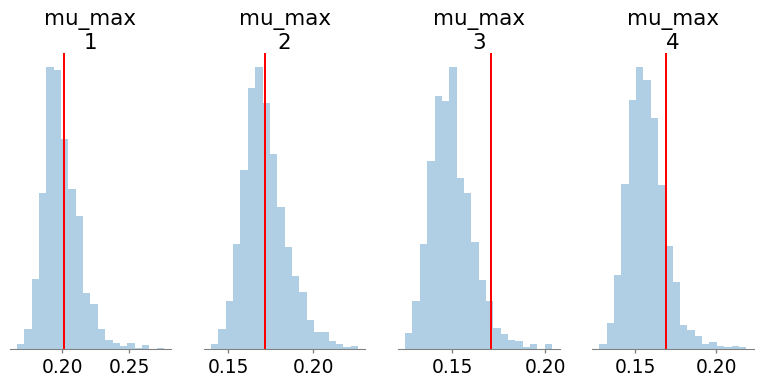

In [19]:
f, axes = plt.subplots(1, 4, figsize=[10, 4])
axes = az.plot_posterior(
    idata_posterior,
    kind="hist",
    bins=20,
    var_names=["mu_max"],
    ax=axes,
    point_estimate=None,
    hdi_prob="hide"
)
for ax, true_value in zip(axes, true_param_values["mu_max"]):
    ax.axvline(true_value, color="red")

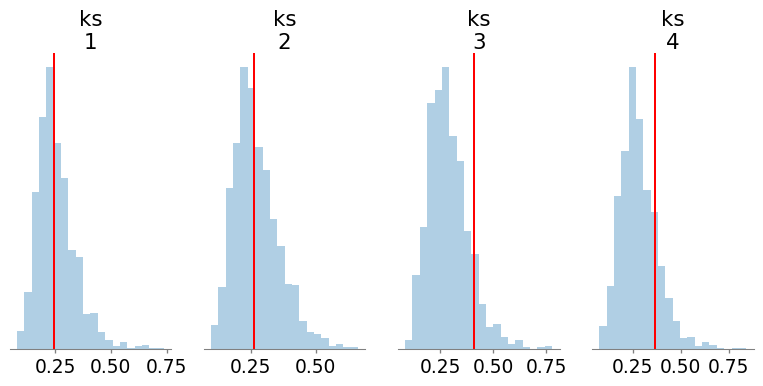

In [20]:
f, axes = plt.subplots(1, 4, figsize=[10, 4])
axes = az.plot_posterior(
    idata_posterior,
    kind="hist",
    bins=20,
    var_names=["ks"],
    ax=axes,
    point_estimate=None,
    hdi_prob="hide"
)
for ax, true_value in zip(axes, true_param_values["ks"]):
    ax.axvline(true_value, color="red")

## References

Allen, Rosalind J, and Bartłomiej Waclaw. 2019. “Bacterial Growth: A
Statistical Physicist’s Guide.” *Reports on Progress in Physics.
Physical Society (Great Britain)* 82 (1): 016601.
<https://doi.org/10.1088/1361-6633/aae546>.

Timonen, Juho, Nikolas Siccha, Ben Bales, Harri Lähdesmäki, and Aki
Vehtari. 2022. “An Importance Sampling Approach for Reliable and
Efficient Inference in Bayesian Ordinary Differential Equation Models.”
arXiv. <https://doi.org/10.48550/arXiv.2205.09059>.